# Trabajo Final de Estadística 2018
- Autor: Emiliano López



## Hidrómetro

Resumen: En el siguiente análisis si estudian las mediciones de la altura del Río Paraná registradas por dos metodologías diferentes, las realizadas por Prefectura Naval observando la escala hidrométrica en forma manual del Puerto de Santa Fe, y las tomadas en forma automática por un dispositivo electrónico desarrollado en el CENtro de Estudios Hidroambientales (CENEHA) usando un distanciómetro acústico como sensor de nivel. 

### Lectura y Visualización

In [ ]:
options(warn=-1)
datosRio = read.csv("datos/hidrometro/ceneha_vs_prefectura.csv", sep=";")
datosRio$FechayHora = as.POSIXct(datosRio$FechayHora, format = "%d/%m/%Y %H:%M")
#str(datosRio)
attach(datosRio)
#head(datosRio)

In [ ]:
plot(FechayHora, AlturaCeneha, col="blue", main="Altura del Río Paraná (Puerto Santa Fe)",xlab="Fecha y hora", ylab="Altura [m]", type="lines")
lines(FechayHora, AlturaPrefectura,col="red")
legend("bottom", inset=.05, c("CENEHA","Prefectura"), fill=c("blue","red"), horiz=TRUE)
grid(nx = 20, ny = 20, col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE)

### Modelo
- Usamos un modelo lineal: $Y = \beta_0 + \beta_1 X_t + \epsilon_t$

Donde:
- Desplazamiento: $\beta_0 = 0.153339$,  $SE=0.009352$
- Pendiente: $\beta_1 = 0.953815$, $SE=0.002592$

In [ ]:
modeloRio = lm(AlturaPrefectura ~ AlturaCeneha)
summary(modeloRio)

In [ ]:
plot(modeloRio)

El ajuste de este modelo de regresión lineal nos queda:

$$E(Y_t|X_t) = 0.153339 + 0.953815 X_t$$

In [ ]:
plot(FechayHora, AlturaCeneha, col="blue", main="Altura del Río Paraná (Puerto Santa Fe)",xlab="Fecha y hora", ylab="Altura [m]", type="lines")
lines(FechayHora, AlturaPrefectura,col="red")
legend("bottom", inset=.05, c("CENEHA","Prefectura", "Modelo"), fill=c("blue","red", "green"), horiz=TRUE)
grid(nx = 20, ny = 20, col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE)

# superponemos el modelo
lines(FechayHora, modeloRio$fitted.values, col='green')

### Outliers
- Corregimos valores anómalos

In [ ]:
library(car)
outlierTest(modeloRio)

In [ ]:
# Reemplazo los outliers por el promedio de sus valores vecinos que están correctos
AlturaPrefectura[166] = (AlturaPrefectura[167] + AlturaPrefectura[165])/2.0
AlturaCeneha[291] = (AlturaCeneha[290] + AlturaCeneha[292])/2.0
AlturaCeneha[306] = (AlturaCeneha[305] + AlturaCeneha[307])/2.0


modeloRioFixed = lm(AlturaPrefectura ~ AlturaCeneha)

outlierTest(modeloRioFixed)
influenceIndexPlot(modeloRioFixed)

In [ ]:
plot(FechayHora, AlturaCeneha, col="blue", main="Corregido",xlab="Fecha y hora", ylab="Altura [m]", type="lines")
lines(FechayHora, AlturaPrefectura,col="red")
legend("bottom", inset=.05, c("CENEHA","Prefectura", "Modelo"), fill=c("blue","red", "green"), horiz=TRUE)
grid(nx = 20, ny = 20, col = "lightgray", lty = "dotted", lwd = par("lwd"), equilogs = TRUE)

# superponemos el modelo
lines(FechayHora, modeloRioFixed$fitted.values, col='green')

### Dispersión Prefectura vs CENEHA

- Vemos el gráfico de dispersión con los outliers corregidos 

In [ ]:
plot(AlturaPrefectura~AlturaCeneha,col='yellow',pch=20)

### Supuestos del modelo
- **Normalidad**

In [ ]:
qqnorm(modeloRioFixed$residuals)
qqline(modeloRioFixed$residuals)

- **Varianza constante:** parecería que para este caso no funciona el leveneTest, sin embargo si probamos con ncvTest nos da un pvalor muy pequeño. ¿Corresponde analizar las varianzas acá? porque no tenemos diferentes tratamientos.

In [ ]:
ncvTest(modeloRioFixed)

- **Independencia de los residuos**

    - Veremos que no es posible asegurar la independencia de los errores
    - Cada valor es dependiente del anterior
    
#### Gráfico de rachas 

Como los datos han sido colectados a través del tiempo puede ocurrir una correlación serial. Graficando los residuos vs el orden temporal en el que los datos fuerfon colectados podemos evaluar los patrones. En patrón que se observará muestra una correlación serial positiva en la cual los residuos tienden a seguirse en el tiempo por residuos del mismo signo y de aproximadamente el mismo tamaño, de aquí que se lo demonina rachas. Vemos que hay rachas lejos de la media 0, por encima y otras por debajo.

In [ ]:
plot(FechayHora, modeloRioFixed$residuals, type='o',  ylab = 'Residuals', xlab = 'Fitted values',)
abline(h=0,col='red')

#### Gráfico de residuos adyacentes

Como la mayoria de los puentos están en el primer y tercer cuadrante: **correlacion serial presente**. El valor del desvío en un punto es similar al del punto mas reciente en el tiempo. 

In [ ]:
n = length(AlturaCeneha)
residuos = modeloRioFixed$residuals
pasado = residuos[-n]   # elimina el último
presente = residuos[-1] # elimina el primero
plot(presente~pasado)
abline(h = 0, v = 0)

### Estimamos el primer coeficiente de correlación serial (autocorrelación)

- H0: $\alpha = 0$
- H1: $\alpha \neq 0$

Ahora $\alpha$ será aproximado por el coeficiente de correlación serial $$r1 = c1/c0$$, que es similar a la pendiente de la recta en la regresión.

- Si r1 = 0 no existe correlación serial y por lo tanto el factor de ajuste es 1;
- Si r1 > 0 el factor de ajuste es más grande que 1;
- Si r1 < 0 el factor de ajuste es más chico que 1;

In [ ]:
s = length(residuos)
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(s))>qnorm(1-0.05/2)

**Como me da verdadero entonces el coeficiente de correlacion es no nulo y sostengo que hay correlacion entre los datos y hago filtering**

### Regresión con variables filtradas

Crear nuevas variables respuestas y explicativas tales que el coeficiente de regresión sea el mismo pero que los residuos sean independientes

In [ ]:
V = AlturaPrefectura[2:s] - r1 * AlturaPrefectura[1:(s-1)]
U = AlturaCeneha[2:s] -r1*AlturaCeneha[1:(s-1)]
modeloF1 = lm(V~U)
summary(modeloF1)

**Estudiamos los residuos del modelo filtrado**

In [ ]:
par(mfrow=c(2,2))
plot(modeloF1)
dev.off()

In [ ]:
plot(U, modeloF1$residuals)
#lines(U,modeloF$residuals)
abline(h=0,col='red')

In [ ]:
#comparo el presente vs el pasado
residuosF1 = modeloF1$residuals
sF1 = length(residuosF1)
pasadoF1 = residuosF1[1:(sF1-1)]
presenteF1=residuosF1[2:(sF1)]

plot(presenteF1~pasadoF1,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [ ]:
#hipotesis de que hay correlacion
c1F1=1/(sF1-1)*sum(presenteF1*pasadoF1)
c0F1=1/(sF1-1)*sum(residuosF1^2)

r1F1=c1F1/c0F1

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F1*sqrt(sF1))>qnorm(1-0.05/2)

# otro test podría ser este
#library("randtests")
#runs.test(residuosF)

**Debemos volver a hacer un filtrado porque aun no eliminamos la independencia**

In [ ]:
V2 = V[2:sF1] - r1F1 * V[1:(sF1-1)]
U2 = U[2:sF1] - r1F1 * U[1:(sF1-1)]

modeloF2 = lm(V2~U2)
summary(modeloF2)

#comparo el presente vs el pasado
residuosF2 = modeloF2$residuals
sF2 = length(residuosF2)
pasadoF2 = residuosF2[1:(sF2-1)]
presenteF2=residuosF2[2:(sF2)]

plot(presenteF2~pasadoF2,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [ ]:
#hipotesis de que hay correlacion
c1F2=1/(sF2-1)*sum(presenteF2*pasadoF2)
c0F2=1/(sF2-1)*sum(residuosF2^2)

r1F2=c1F2/c0F2

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F2*sqrt(sF2))>qnorm(1-0.05/2)

In [ ]:
# 3er filtrado

V3 = V2[2:sF2] - r1F2 * V2[1:(sF2-1)]
U3 = U2[2:sF2] - r1F2 * U2[1:(sF2-1)]

modeloF3 = lm(V3~U3)
summary(modeloF3)
#comparo el presente vs el pasado
residuosF3 = modeloF3$residuals
sF3 = length(residuosF3)

pasadoF3 = residuosF3[1:(sF3-1)]
presenteF3=residuosF3[2:(sF3)]

plot(presenteF3~pasadoF3,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [ ]:
#hipotesis de que hay correlacion
c1F3=1/(sF3-1)*sum(presenteF3*pasadoF3)
c0F3=1/(sF3-1)*sum(residuosF3^2)

r1F3=c1F3/c0F3

beta1 = 0.951060
SE_beta1 = 0.005658

#0.948482   0.005658

#testeo si r1 es 0 o no, 
# es no 0 si es TRUE
abs(r1F3*sqrt(sF3))>qnorm(1-0.05/2)


- EL RESULTADO PREVIO (FALSE) NOS INDICA QUE NOS HEMOS LIBERADO DE LA DEPENDENCIA TEMPORAL

- Resta construir el Intervalo de Confianza para corroborar si se acepta o rechaza el siguiente test


*** 

- H0: $\beta_1 = 1$
- H1: $\beta_1 \neq 1$

*** 

- A continuación observamos el IC

### Armamos el Intervalo de Confianza

In [ ]:
c(beta1 - qt(1-0.05/2,sF3-2)*SE_beta1, beta1 + qt(1-0.05/2,sF3-2)*SE_beta1)

- Vemos que no contiene al 1!!! 

## Humedad ambiente

Resumen: en el siguiente trabajo se analizan la temperatura y humedad ambiente, ambas registradas con dos equipos diferentes. Por un lado por los sensores provistos por una estación Eddy Covariance de Campbell Scientific y por el otro, con el sensor DHT22. Los valores registrados por la estación son los tomados como verdaderos, ya que es un equipo profesional y muy utilizado para fines científicos.  El sensor DH22 es un sensor muy económico del que se pretendende evaluar la confiabilidad de sus mediciones. 

In [22]:
rm(list=ls())
datosHT = read.csv("datos/dht_eddyCovariance/dht_vs_eddy.csv", sep=";")
datosHT$FechayHora = as.POSIXct(datosHT$FechayHora, format = "%d/%m/%Y %H:%M")
#str(datosHT)
attach(datosHT)
head(datosHT)

FechayHora,Temperatura.DHT,Humedad.DHT,Temperatura.Eddy,Humedad.Eddy
2014-12-29 10:45:00,29.1,72.3,28.10,63.05
2014-12-29 11:00:00,29.3,73.6,28.09,63.25
2014-12-29 11:15:00,29.4,69.0,28.43,60.17
2014-12-29 11:30:00,29.8,68.8,28.50,59.70
2014-12-29 11:45:00,30.2,65.4,29.04,57.51
2014-12-29 12:00:00,30.1,65.1,29.04,55.13


Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

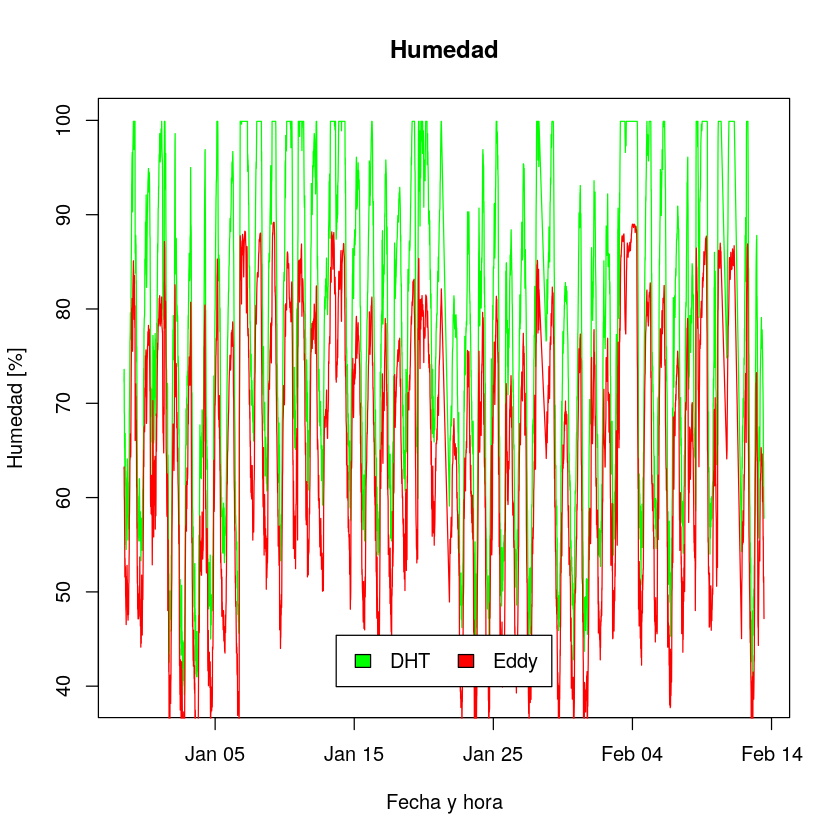

In [23]:
plot(FechayHora, Humedad.DHT, col="green", main="Humedad", xlab="Fecha y hora", ylab="Humedad [%]", type="lines")
lines(FechayHora, Humedad.Eddy,col="red")
legend("bottom", inset=.05, c("DHT","Eddy"), fill=c("green","red"), horiz=TRUE)

In [ ]:
library(car)

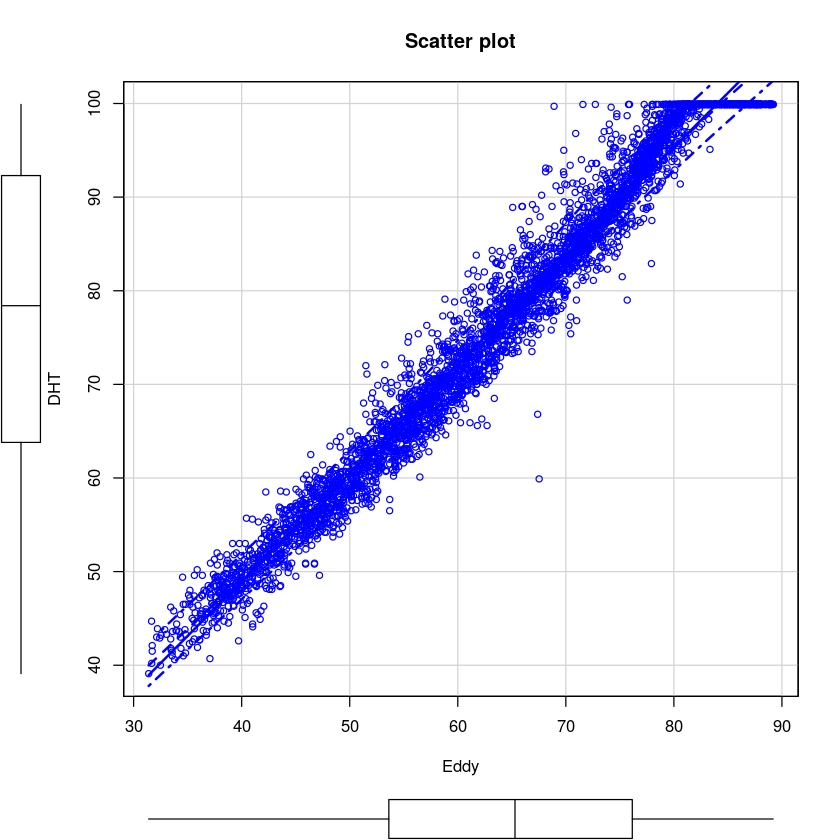

In [24]:
scatterplot(Humedad.DHT ~ Humedad.Eddy, data=datosHT, xlab="Eddy", ylab="DHT", main="Scatter plot") 

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

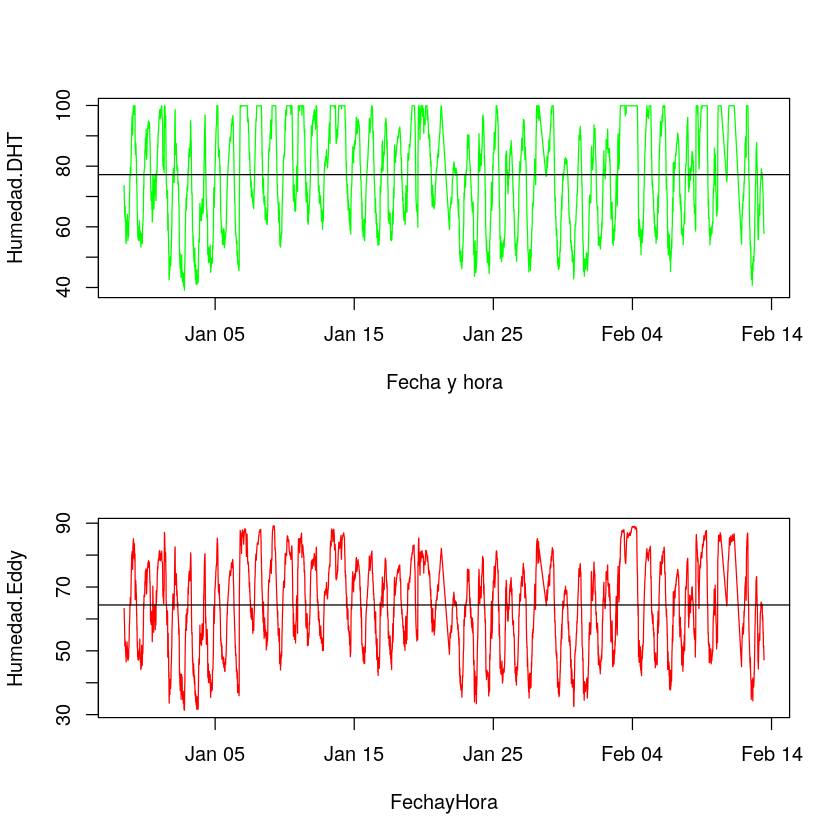

In [25]:
par(mfrow = c(2,1))
plot(Humedad.DHT~FechayHora, col="green", xlab="Fecha y hora", type="l")
abline(h = mean(Humedad.DHT), v = 0,col='black')
plot(Humedad.Eddy~FechayHora,col="red", type="lines")
abline(h = mean(Humedad.Eddy), v = 0,col='black')

In [32]:
modeloHum1 = lm(Humedad.Eddy ~ Humedad.DHT)
summary(modeloHum1)


Call:
lm(formula = Humedad.Eddy ~ Humedad.DHT)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.320  -1.336   0.058   1.324  17.657 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.330121   0.172513  -1.914   0.0557 .  
Humedad.DHT  0.838111   0.002185 383.629   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.357 on 4216 degrees of freedom
Multiple R-squared:  0.9722,	Adjusted R-squared:  0.9721 
F-statistic: 1.472e+05 on 1 and 4216 DF,  p-value: < 2.2e-16


### Outliers

In [33]:
library(car)
outlierTest(modeloHum1)

      rstudent unadjusted p-value Bonferonni p
2020  7.543761         5.5604e-14   2.3454e-10
3914 -6.104258         1.1258e-09   4.7486e-06
3913 -5.030458         5.0967e-07   2.1498e-03
794   4.994070         6.1511e-07   2.5945e-03
3525 -4.538394         5.8263e-06   2.4575e-02

### Independencia de residuos
#### Gráfico de rachas

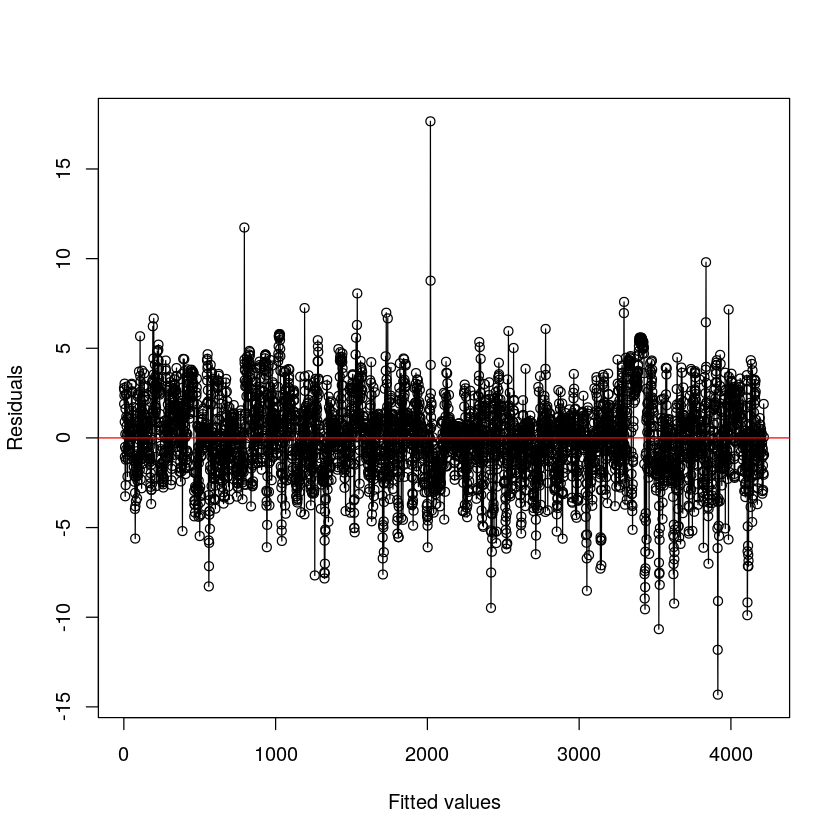

In [34]:
plot(modeloHum1$residuals, type='o',  ylab = 'Residuals', xlab = 'Fitted values',)
abline(h=0,col='red')

#### Gráfico de residuos adyacentes

[1] 4218

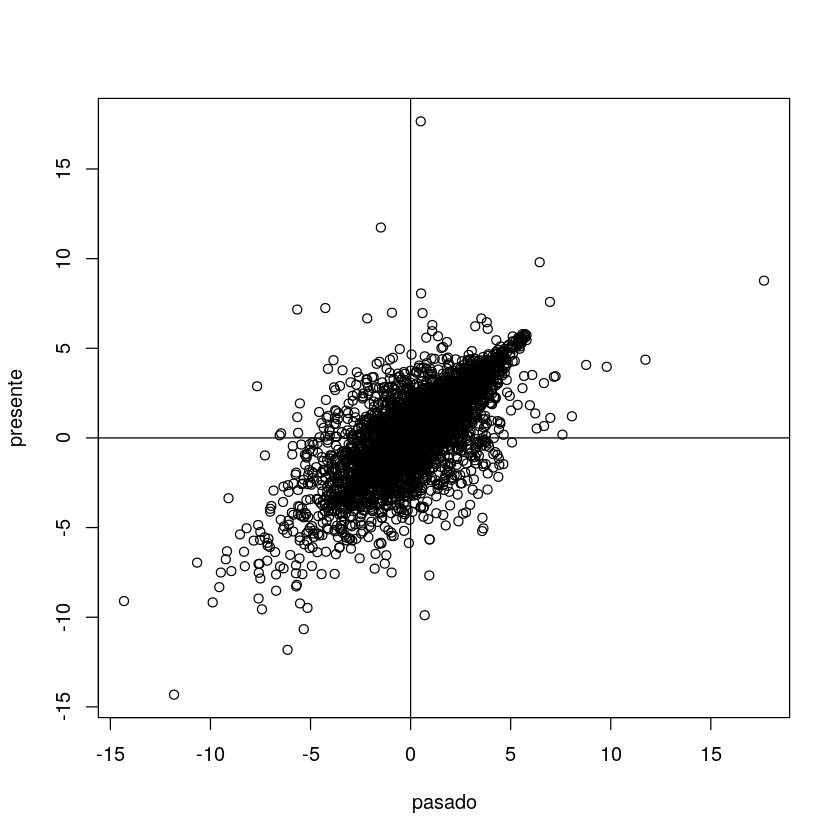

In [37]:
(n = length(Humedad.DHT))
residuos = modeloHum1$residuals
pasado = residuos[-n]   # elimina el último
presente = residuos[-1] # elimina el primero
plot(presente~pasado)
abline(h = 0, v = 0)

### Test

In [36]:
(s = length(residuos))
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(s))>qnorm(1-0.05/2)

[1] 4218

[1] 0.6943989

[1] TRUE

### Filtrado de variables (1)

In [38]:
V1 = Humedad.Eddy[2:s] - r1 * Humedad.Eddy[1:(s-1)]
U1 = Humedad.DHT[2:s] - r1 * Humedad.DHT[1:(s-1)]
modeloHumF1 = lm(V1~U1)
summary(modeloHumF1)


Call:
lm(formula = V1 ~ U1)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.2533  -0.7781   0.0729   0.9010  17.0550 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.653955   0.113578   5.758 9.13e-09 ***
U1          0.806078   0.004687 171.976  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.687 on 4215 degrees of freedom
Multiple R-squared:  0.8753,	Adjusted R-squared:  0.8752 
F-statistic: 2.958e+04 on 1 and 4215 DF,  p-value: < 2.2e-16


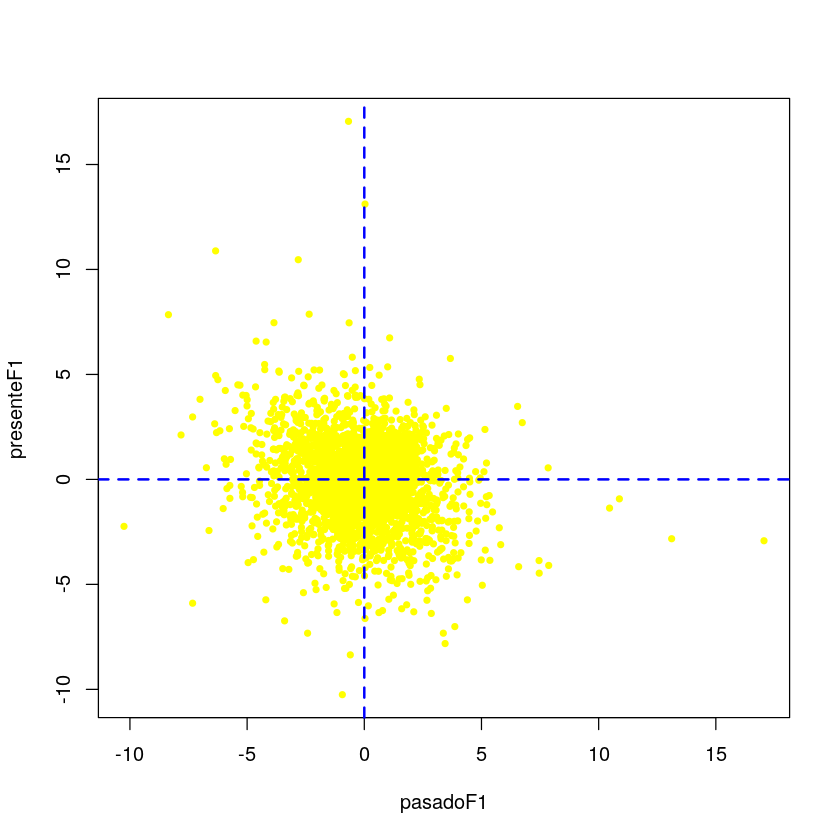

In [39]:
#comparo el presente vs el pasado
residuosF1 = modeloHumF1$residuals
sF1 = length(residuosF1)
pasadoF1 = residuosF1[1:(sF1-1)]
presenteF1 = residuosF1[2:(sF1)]

plot(presenteF1~pasadoF1, col='yellow', pch=20)
abline(h=0, v=0, col='blue', lwd=2, lty=2)

In [40]:
#hipotesis de que hay correlacion
c1F1=1/(sF1-1)*sum(presenteF1*pasadoF1)
c0F1=1/(sF1-1)*sum(residuosF1^2)

r1F1=c1F1/c0F1

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F1*sqrt(sF1))>qnorm(1-0.05/2)

[1] TRUE

### Filtrado de variables (2)


Call:
lm(formula = V2 ~ U2)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4264  -0.7994   0.0714   0.8922  17.0447 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.483609   0.114224   4.234 2.35e-05 ***
U2          0.815746   0.004155 196.331  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.67 on 4214 degrees of freedom
Multiple R-squared:  0.9014,	Adjusted R-squared:  0.9014 
F-statistic: 3.855e+04 on 1 and 4214 DF,  p-value: < 2.2e-16


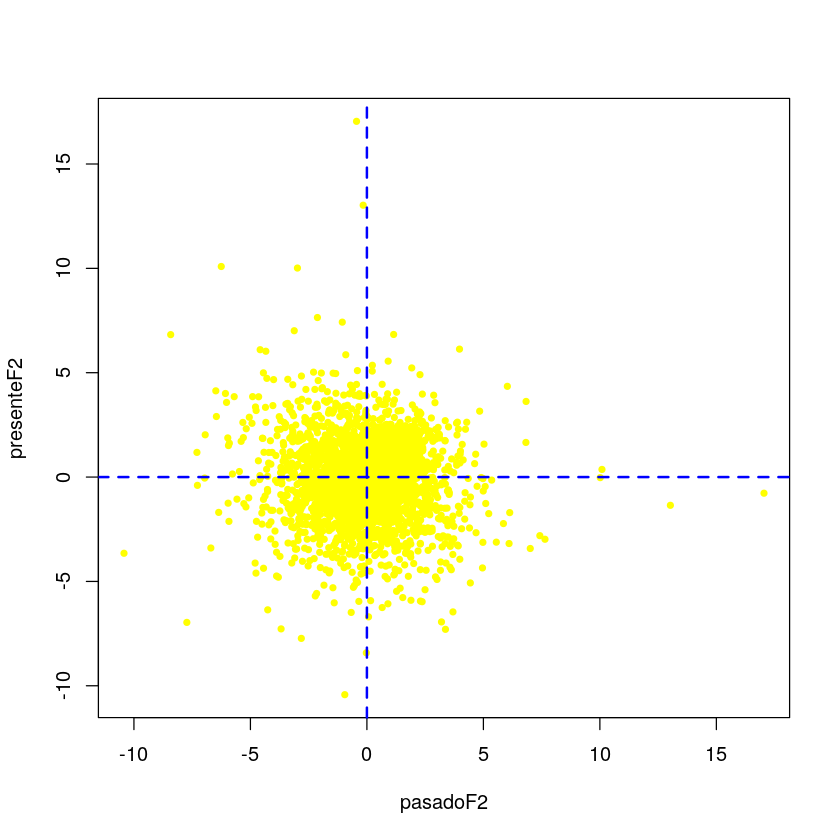

In [41]:
V2 = V1[2:sF1] - r1F1 * V1[1:(sF1-1)]
U2 = U1[2:sF1] - r1F1 * U1[1:(sF1-1)]

modeloHumF2 = lm(V2~U2)
summary(modeloHumF2)

#comparo el presente vs el pasado
residuosF2 = modeloHumF2$residuals
sF2 = length(residuosF2)
pasadoF2 = residuosF2[1:(sF2-1)]
presenteF2=residuosF2[2:(sF2)]

plot(presenteF2~pasadoF2,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [42]:
#hipotesis de que hay correlacion
c1F2=1/(sF2-1)*sum(presenteF2*pasadoF2)
c0F2=1/(sF2-1)*sum(residuosF2^2)

r1F2=c1F2/c0F2

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F2*sqrt(sF2))>qnorm(1-0.05/2)

[1] FALSE

### Intervalo de confianza

In [43]:
beta1 = 0.838111
SE_beta1 = 0.002185


c(beta1 - qt(1-0.05/2,sF2-2)*SE_beta1, beta1 + qt(1-0.05/2,sF2-2)*SE_beta1)

[1] 0.8338272 0.8423948

## Temperatura ambiente

In [ ]:
plot(FechayHora, Temperatura.DHT, col="green", main="Temperatura aire", xlab="Fecha y hora", ylab="Temperatura [°C]")#, type="lines")
lines(FechayHora, Temperatura.Eddy, col="red")
legend("bottom", inset=.05, c("DHT","Eddy"), fill=c("green","red"), horiz=TRUE)

In [ ]:
par(mfrow = c(2,1))
plot(Temperatura.DHT~FechayHora, col="green", xlab="Fecha y hora", type="l")
abline(h = mean(Temperatura.DHT), v = 0,col='black')
plot(FechayHora, Temperatura.Eddy,col="red", type="lines")
abline(h = mean(Temperatura.Eddy), v = 0,col='black')

In [ ]:
scatterplot(Temperatura.DHT,Temperatura.Eddy, data=datosHT, xlab="Eddy", ylab="DHT22", main="Scatter plot") 

In [ ]:
modeloTemp1 = lm(Temperatura.Eddy ~ Temperatura.DHT)
summary(modeloTemp1)

In [ ]:
outlierTest(modeloTemp1)
influenceIndexPlot(modeloTemp1)

### Independencia de residuos
#### Gráfico de rachas

In [ ]:
plot(FechayHora, modeloTemp1$residuals, type='o',  ylab = 'Residuals', xlab = 'Fitted values',)
abline(h=0,col='red')

#### Gráfico de residuos adyacentes

In [ ]:
(n = length(Temperatura.DHT))
residuos = modeloTemp1$residuals
pasado = residuos[-n]   # elimina el último
presente = residuos[-1] # elimina el primero
plot(presente~pasado)
abline(h = 0, v = 0)

### Test

In [ ]:
(s = length(residuos))
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(s))>qnorm(1-0.05/2)

### Filtrado de variables (1)

In [ ]:
V1 = Temperatura.Eddy[2:s] - r1 * Temperatura.Eddy[1:(s-1)]
U1 = Temperatura.DHT[2:s] -r1*Temperatura.DHT[1:(s-1)]
modeloTempF1 = lm(V1~U1)
summary(modeloTempF1)

In [ ]:
#comparo el presente vs el pasado
residuosF1 = modeloTempF1$residuals
sF1 = length(residuosF1)
pasadoF1 = residuosF1[1:(sF1-1)]
presenteF1=residuosF1[2:(sF1)]

plot(presenteF1~pasadoF1, col='yellow', pch=20)
abline(h=0, v=0, col='blue', lwd=2, lty=2)

In [ ]:
#hipotesis de que hay correlacion
c1F1=1/(sF1-1)*sum(presenteF1*pasadoF1)
c0F1=1/(sF1-1)*sum(residuosF1^2)

r1F1=c1F1/c0F1

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F1*sqrt(sF1))>qnorm(1-0.05/2)

### Filtrado de variables (2)

In [ ]:
V2 = V1[2:sF1] - r1F1 * V1[1:(sF1-1)]
U2 = U1[2:sF1] - r1F1 * U1[1:(sF1-1)]

modeloTempF2 = lm(V2~U2)
summary(modeloTempF2)

#comparo el presente vs el pasado
residuosF2 = modeloTempF2$residuals
sF2 = length(residuosF2)
pasadoF2 = residuosF2[1:(sF2-1)]
presenteF2=residuosF2[2:(sF2)]

plot(presenteF2~pasadoF2,col='yellow',pch=20)
abline(h=0,v=0,col='blue',lwd=2,lty=2)

In [ ]:
#hipotesis de que hay correlacion
c1F2=1/(sF2-1)*sum(presenteF2*pasadoF2)
c0F2=1/(sF2-1)*sum(residuosF2^2)

r1F2=c1F2/c0F2

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F2*sqrt(sF2))>qnorm(1-0.05/2)

In [ ]:
beta1 = 0.933781
SE_beta1 = 0.00409

c(beta1 - qt(1-0.05/2,sF2-2)*SE_beta1, beta1 + qt(1-0.05/2,sF2-2)*SE_beta1)

## Temperatura del suelo

Resumen: En este caso se contrasta la temperatura de suelo registrada por el sensor HydraProbeII de Stevens con la medida por el sensor DS18B20. 

In [9]:
rm(list=ls())
datosTS = read.csv("datos/stevens_fc_ds/ds_vs_stevensTiempo.csv", sep=",")
#str(datosTS)
head(datosTS)
attach(datosTS)

tiempo,Stevens,DS18B20
0.15,25.6,26.00
0.30,26.2,26.06
0.45,26.2,26.00
0.60,26.2,26.00
0.75,26.2,26.00
0.90,26.2,26.00


The following objects are masked from datosTS (pos = 5):

    DS18B20, Stevens, tiempo



In [10]:
#DS18B20_2 = DS18B20 + 0.25

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

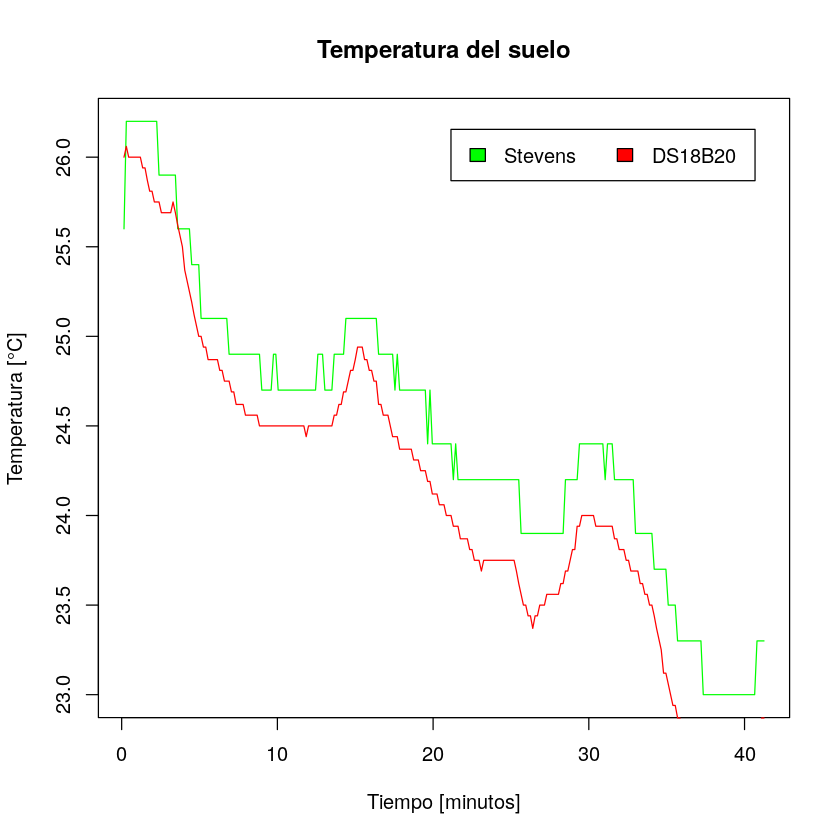

In [11]:
plot(tiempo, Stevens, col="green", main="Temperatura del suelo", xlab="Tiempo [minutos]", ylab="Temperatura [°C]", type="lines")
lines(tiempo, DS18B20, col="red")
legend("topright", inset=.05, c("Stevens","DS18B20"), fill=c("green","red"), horiz=TRUE)

In [5]:
library(car)

Loading required package: carData


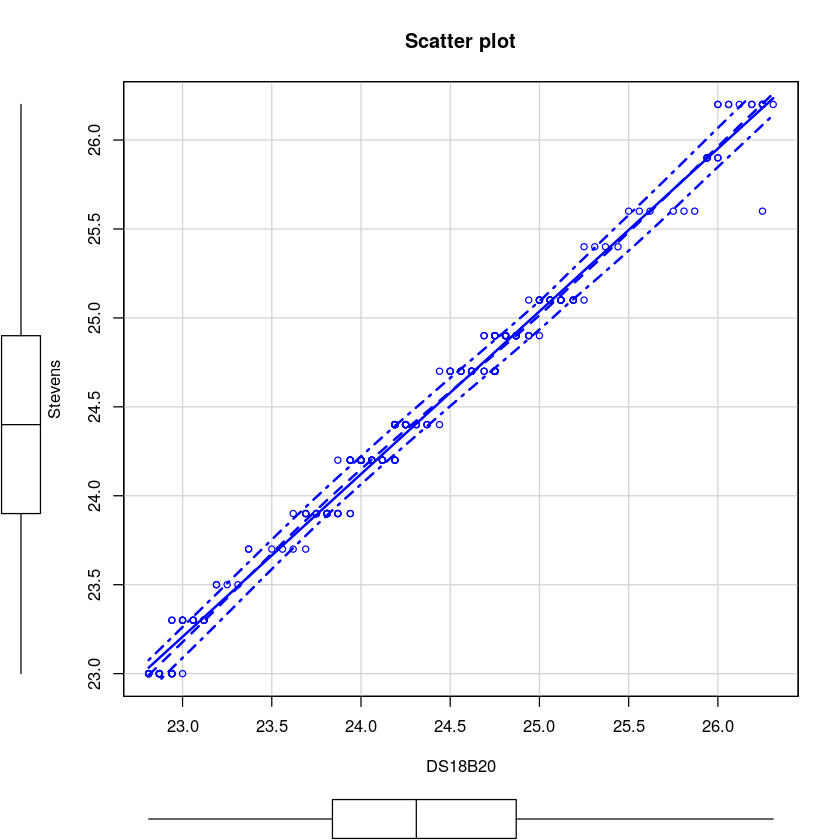

In [6]:
scatterplot(Stevens ~ DS18B20_2, data=datosTS, xlab="DS18B20", ylab="Stevens", main="Scatter plot") 

In [12]:
modeloTempSuelo = lm(Stevens ~ DS18B20)
summary(modeloTempSuelo)


Call:
lm(formula = Stevens ~ DS18B20)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58007 -0.06745  0.00841  0.07640  0.24860 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.398173   0.158704   15.11   <2e-16 ***
DS18B20     0.914688   0.006575  139.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09541 on 273 degrees of freedom
Multiple R-squared:  0.9861,	Adjusted R-squared:  0.986 
F-statistic: 1.935e+04 on 1 and 273 DF,  p-value: < 2.2e-16


### Independencia de residuos

#### Gráfica de rachas

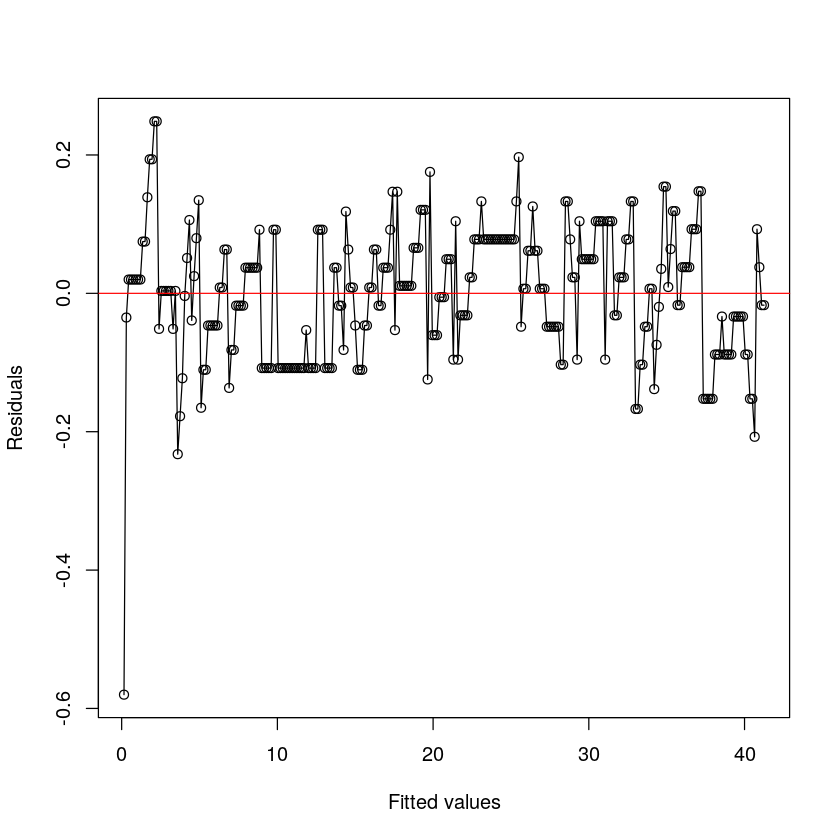

In [14]:
plot(tiempo, modeloTempSuelo$residuals, type='o',  ylab = 'Residuals', xlab = 'Fitted values',)
abline(h=0,col='red')

### Gráfico residuos adyacentes

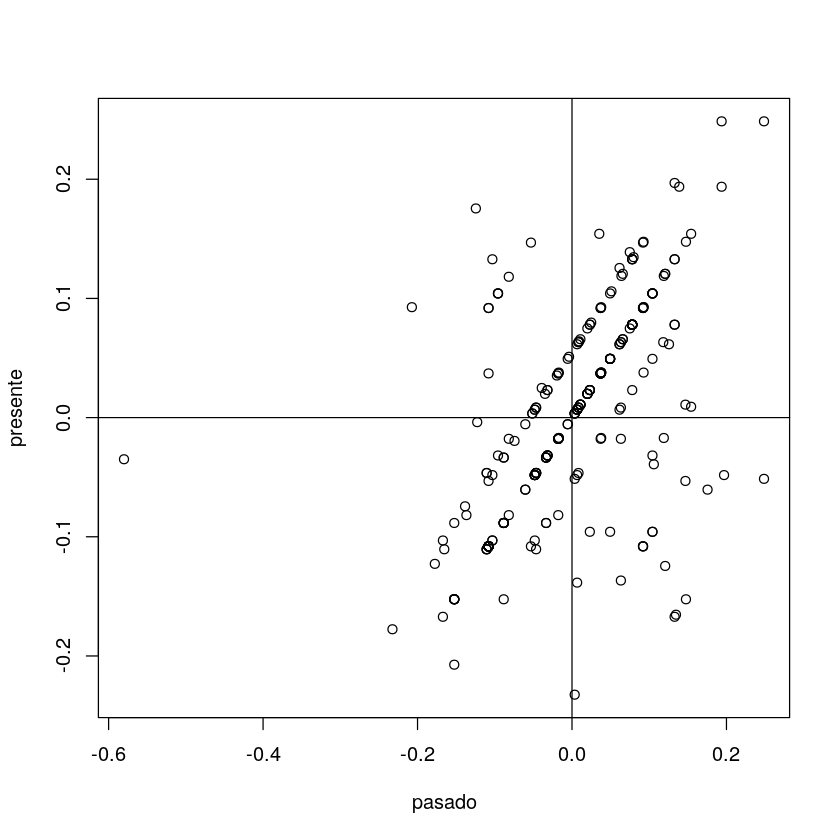

In [16]:
n = length(DS18B20)
residuos = modeloTempSuelo$residuals
pasado = residuos[-n]   # elimina el último
presente = residuos[-1] # elimina el primero
plot(presente~pasado)
abline(h = 0, v = 0)

## Test

In [17]:
(s = length(residuos))
c1 = sum(presente*pasado)/(n-1)
c0 = sum(presente^2)/(n-1)
(r1 = c1/c0)
abs(r1*sqrt(s))>qnorm(1-0.05/2)

[1] 275

[1] 0.5761684

[1] TRUE

### Filtrado de variables (1)

In [18]:
V1 = Stevens[2:s] - r1 * Stevens[1:(s-1)]
U1 = DS18B20[2:s] - r1 * DS18B20[1:(s-1)]
modeloTempSueloF1 = lm(V1~U1)
summary(modeloTempSueloF1)


Call:
lm(formula = V1 ~ U1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.249075 -0.042576  0.002371  0.035094  0.288003 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.91015    0.12660   7.189  6.3e-12 ***
U1           0.92530    0.01239  74.702  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07528 on 272 degrees of freedom
Multiple R-squared:  0.9535,	Adjusted R-squared:  0.9534 
F-statistic:  5580 on 1 and 272 DF,  p-value: < 2.2e-16


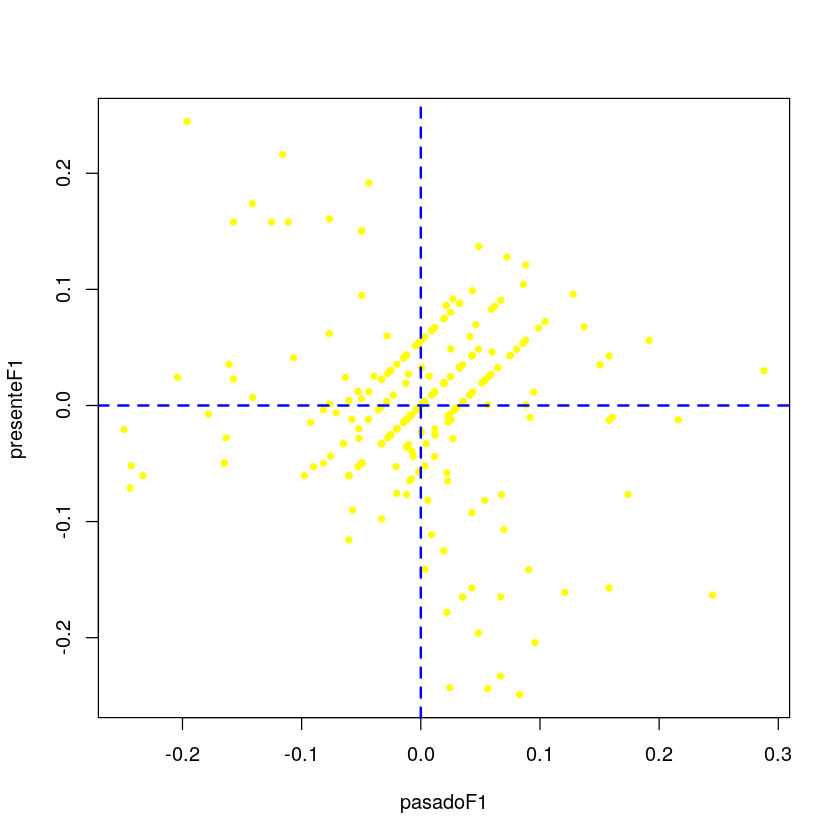

In [19]:
#comparo el presente vs el pasado
residuosF1 = modeloTempSueloF1$residuals
sF1 = length(residuosF1)
pasadoF1 = residuosF1[1:(sF1-1)]
presenteF1 = residuosF1[2:(sF1)]

plot(presenteF1~pasadoF1, col='yellow', pch=20)
abline(h=0, v=0, col='blue', lwd=2, lty=2)

In [20]:
#hipotesis de que hay correlacion
c1F1=1/(sF1-1)*sum(presenteF1*pasadoF1)
c0F1=1/(sF1-1)*sum(residuosF1^2)

r1F1=c1F1/c0F1

#testeo si r1 es 0 o no, 
# es no 0 si es es TRUE
abs(r1F1*sqrt(sF1))>qnorm(1-0.05/2)

[1] FALSE

### Intervalo de confianza

In [21]:
beta1 = 0.914688
SE_beta1 = 0.006575

c(beta1 - qt(1-0.05/2,sF1-2)*SE_beta1, beta1 + qt(1-0.05/2,sF1-2)*SE_beta1)

[1] 0.9017436 0.9276324


<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-danger">
<b>Just don't:</b> In general, avoid the red boxes. These should only be
used for actions that might cause data loss or another major issue.
</div>

<div class="alert alert-block alert-info">
<b>-</b> Tenemos datos registrados en el tiempo: no son independientes
</div>